In [1]:
# Customization imports

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import time

# Export dataFrame's as images
import dataframe_image as dfi

In [2]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import auc as auc_temp

In [3]:
# import my utility methods for this project
import utils_practical_2 as my_utils

In [4]:
# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [5]:
# Global format rules

# Page width to use for wide figures - make it consistent across the project
page_width=10

# Clean up axes labels
axes_fonts = {'fontweight': 'bold'}
title_fonts = {'fontweight': 'bold', 'fontsize': 14}

# Seaborn over-rides
sns.set_theme(style='darkgrid')

# On to Modeling ...

**This notebook picks up from the Data Investigation (see ```DataInvestigation.ipynb```)**

[Local file](DataInvestigation.ipynb)
[Github](https://github.com/fazeelgm/UCB_ML_AI_PracticalApp_II/blob/main/DataInvestigation.ipynb)

## Data Cleanup

The data cleansing results are as follows:

In [9]:
# vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

In [10]:
# vehicles_cleansed.info()

# On to Modeling ...

While investigating the different features of our dataset during the data investigation, I learned two things:

1. The data is very noisy with extreme outliers - I removed null data and outliers as much as possible
   * 66,180 samples were dropped, preserving 84.50% of the original data
3. To aid in this effort, I researched the used car marketplace to get some idea of pricing, important features that drive price and potential inventory segments

## Initial Hypothesis

Based on Price inspection, a potential hypothesis arose that the used car inventory is _segmented_ based on the following price bands:

![](images/candidate-price-segments.png)

In addition, market research suggested that typical used cars can be categoriezed into price ranges like Budget, Mid, Luxury, etc. that will be based on feature groups. I looked at ```<price, year, condition, odometer>``` combinations and saw that there was clustering behavior as shown by the scatter plots below:

![](images/scatter-price-odo-condition-budget.png)
![](images/scatter-price-odo-year-entry.png)

So, I will now use clustering techniques to see if we can observe natural clustering of features in our sample population.

# Final Modeling

## Data Cleaning

In [15]:
vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

Reading data/vehicles.csv ... Done: (426880, 18)

Cleansing price column ... 
... Removing price outliers using ModZ method ... 
... ModZ: 9450.0, med: 13950.0, const: 0.6745
... Time: 0.1857130527496338
... Removed 5,790 outliers
... Removing cars with price = 0 ...  Removed 32,895 rows
Done: (421090, 19) -> (388195, 19)

DropNA from columns: 
... year: 1,029 rows (0.27% of total): 388,195 -> 387,166
... manufacturer: 16,609 rows (4.28% of total): 388,195 -> 371,586
... fuel: 19,173 rows (4.94% of total): 388,195 -> 369,022
... title_status: 26,730 rows (6.89% of total): 388,195 -> 361,465
... odometer: 28,960 rows (7.46% of total): 388,195 -> 359,235
... transmission: 30,742 rows (7.92% of total): 388,195 -> 357,453
Done: (388195, 19) -> (360700, 19)

Dropping columns: ['mod_zscore', 'id', 'model']
... mod_zscore
... id
... model
Done: (360700, 19) -> (360700, 16)

Data Transformations:
... year float -> int: Done
... odometer float -> int: Done

Category Transformations:
... Convert

In [16]:
vehicles_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        360700 non-null  object  
 1   price         360700 non-null  int64   
 2   year          360700 non-null  int64   
 3   manufacturer  360700 non-null  category
 4   condition     223668 non-null  category
 5   cylinders     213522 non-null  category
 6   fuel          360700 non-null  category
 7   odometer      360700 non-null  int64   
 8   title_status  360700 non-null  category
 9   transmission  360700 non-null  category
 10  VIN           219818 non-null  object  
 11  drive         252582 non-null  category
 12  size          104338 non-null  category
 13  type          282300 non-null  category
 14  paint_color   257706 non-null  category
 15  state         360700 non-null  category
dtypes: category(11), int64(3), object(2)
memory usage: 20.3+ MB


In [17]:
vehicles_cleansed.columns

Index(['region', 'price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive',
       'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [18]:
# Create a copy of the clean data
data = vehicles_cleansed.copy()

In [19]:
# Remove unwanted columns
drop_cols = ['region', 'manufacturer', 'VIN', 'paint_color', 'state', 'size']
data.drop(columns=drop_cols, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         360700 non-null  int64   
 1   year          360700 non-null  int64   
 2   condition     223668 non-null  category
 3   cylinders     213522 non-null  category
 4   fuel          360700 non-null  category
 5   odometer      360700 non-null  int64   
 6   title_status  360700 non-null  category
 7   transmission  360700 non-null  category
 8   drive         252582 non-null  category
 9   type          282300 non-null  category
dtypes: category(7), int64(3)
memory usage: 13.4 MB


In [21]:
# data['size'].value_counts()

In [22]:
# data.shape[0] - data['size'].value_counts().sum()

In [23]:
# data[data['size'].isna()]

In [24]:
# data.query('size == ""')['size'].value_counts().sum()

In [25]:
# remove nulls before splitting data

dropna_cols = ['condition', 'cylinders', 'drive', 'type']

print('Dropping nulls: {} -> '.format(data.shape), end='')
# data.dropna(subset=['condition', 'cylinders', 'drive', 'size', 'type'], axis='index', inplace=True)
data.dropna(subset=dropna_cols, axis='index', inplace=True)
print(' {}'.format(data.shape))

Dropping nulls: (360700, 10) ->  (122682, 10)


In [26]:
data.columns

Index(['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'drive', 'type'],
      dtype='object')

## Feature Transformation for Modeling

### Create Train/Test splits

In [29]:
X = data.drop('price', axis='columns')
y = data['price']

# OneHot Encode the features
X = pd.get_dummies(X, drop_first=True)

random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122682 entries, 31 to 426878
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   year                     122682 non-null  int64
 1   odometer                 122682 non-null  int64
 2   condition_fair           122682 non-null  bool 
 3   condition_good           122682 non-null  bool 
 4   condition_like new       122682 non-null  bool 
 5   condition_new            122682 non-null  bool 
 6   condition_salvage        122682 non-null  bool 
 7   cylinders_12 cylinders   122682 non-null  bool 
 8   cylinders_3 cylinders    122682 non-null  bool 
 9   cylinders_4 cylinders    122682 non-null  bool 
 10  cylinders_5 cylinders    122682 non-null  bool 
 11  cylinders_6 cylinders    122682 non-null  bool 
 12  cylinders_8 cylinders    122682 non-null  bool 
 13  cylinders_other          122682 non-null  bool 
 14  fuel_electric            122682 non-null

### Feature Scaling

In [32]:
# Scale the data - we'll use StandardScaler for the baseline models
logging.debug('Scaling data')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Baseline Regression Models

In [34]:
models = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(alpha=1.0),
    'Lasso' : Lasso(alpha=0.1)
}

# save results for tabulation
results_baseline = []

In [35]:
# Evaluate models
def get_model_metrics_as_results(name, clf, scaler, X_test, y_test):
    """
    Build standardized results row given the predictions and y_test values

    :param name: Model name for labeling the row in the table
    :param clf: Fitted classifier to get metrics
    :param scaler: Fitted scaler used for transformation
    :param X_test: Test data used to fit the classifier
    :param y_test: Evaluation data to be used for the metrics
    :return: Returns single row of results summary table containing:
    
        [model_name, MAE, MSE, RMSE, R2_Score, y-intercept]
    """
    
    logging.debug(f'Working on {name}')

    # Get predictions
    y_preds = clf.predict(X_test)

    # get metrics
    mae = mean_absolute_error(y_preds, y_test)
    mse = mean_squared_error(y_preds, y_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_preds)
    score = clf.score(X_test, y_test)
    y_intercept = np.abs(clf.intercept_)
    sname = scaler.__class__.__name__
    
    logging.debug(f'... {name}: Scaler: {sname} MAE: {mae:,.4f}, MSE: {mse:,.4f}, RMSE: {rmse:,.4f}, R2: {r2:,.4f}, Score: {score:,.4f}, y-int: {y_intercept:,.4f}')

    return [name, sname, mae, mse, rmse, score, y_intercept]

In [36]:
# Enable debugging output
# logging.getLogger().setLevel(logging.DEBUG)

results_baseline = []

# iterate over the models and build results DF
for model in models:

    start_time = time.time()
    print(f'Working on {model} ... ', end='')

    # Fit the model
    models[model].fit(X_train_scaled, y_train)
    
    # Append model metrics to results
    results_baseline.append(get_model_metrics_as_results(model, models[model], scaler, X_test_scaled, y_test))

    print(f'Done with {model} ({time.time() - start_time:,.4f} sec)')

# Disable debugging
logging.getLogger().setLevel(logging.INFO)

Working on LinearRegression ... Done with LinearRegression (0.1509 sec)
Working on Ridge ... Done with Ridge (0.0378 sec)
Working on Lasso ... Done with Lasso (1.9855 sec)


In [37]:
# Generate results table
results_baseline_df = pd.DataFrame(results_baseline, 
                                   columns=['Model', 'Scaler', 'MAE', 'MSE', 'RMSE', 'R2 Score', 'Base Price']
                                  ).set_index('Model')


# Export results for README
results_baseline_df_styled = my_utils.df_style_floats(results_baseline_df)
dfi.export(results_baseline_df_styled, 'images/results_baseline_table.png')

print('RESULTS: Baseline metrics without any optimization\n')
results_baseline_df_styled

RESULTS: Baseline metrics without any optimization



,Scaler,MAE,MSE,RMSE,R2 Score,Base Price
Model,,,,,,
LinearRegression,StandardScaler,"5,959.6608","71,289,759.7592","8,443.3263",0.5289,"15,707.9495"
Ridge,StandardScaler,"5,959.6674","71,289,772.2857","8,443.3271",0.5289,"15,707.9495"
Lasso,StandardScaler,"5,959.6765","71,289,852.2068","8,443.3318",0.5289,"15,707.9495"


All the models performed very closely without any clear winners. Given the target variable measurement unit, price in dollars per car:

* All the models showed roughly $8,287 (RMSE) average difference between the predicted and actual prices from the test dataset that was not used for the training of the model
* The R2 Score shows thay they each captured 42.77% of the variance in the price

We will now optimize the models to see if we can improve the results and pick a clear winner.

## Model Tuning: Hyperparameter Tuning and Cross Validation

In [40]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LinearRegression': LinearRegression()
}

cv_param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0], 'random_state' : [random_state]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0], 'random_state' : [random_state]}    
}

scalers = {
    StandardScaler(),
    RobustScaler(),    # default: quantile_range=(25, 75)
    MinMaxScaler()
}

In [41]:
# Toggle debugging output
# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [42]:
#
# Set loops to cross-validate over model / scaler combinations using GridSearchCV
#
# save results for tabulation
results_tuned = []
best_models = {}
best_params = {}
# cv_scores = {}
cv_rmses = {}

# Cross-validation count
cv=5

for scaler in scalers:

    print(f'Working on {scaler} ... ')
    logging.debug(f'Working on {scaler}')

    # Scale X_train
    logging.debug(f'Scaling data using {scaler}')
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    for model in models:

        start_time = time.time()

        print(f'\tWorking on {model} ... ', end='')

        clf = models[model]

        # Handle CV models
        if (model in cv_param_grid):
            logging.debug('{} : {}, Scaler: {}'.format(model, cv_param_grid[model], scaler))
            grid = GridSearchCV(clf, param_grid=cv_param_grid[model], cv=cv, scoring='neg_mean_squared_error')
            grid.fit(X_train_scaled, y_train)
              
            # Save the tuning metrics for this model class
            best_models[model] = grid.best_estimator_
            best_params[model] = grid.best_params_
            logging.debug(f'Best param: {grid.best_params_}')            
            cv_rmses[model] = np.sqrt(-grid.best_score_)

        # Handle non-CV models
        else:
            logging.debug('{}, Scaler: {}'.format(model, scaler))
            clf.fit(X_train_scaled, y_train)
            cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')

            # Save the tuning metrics for this model class
            best_models[model] = clf
            best_params[model] = ''
            cv_rmses[model] = np.sqrt(-np.mean(cv_scores))

        y_preds = best_models[model].predict(X_test_scaled)

        # Get the predictions for this model instance
        score = best_models[model].score(X_test_scaled, y_test)
        r2 = r2_score(y_test, y_preds)
        logging.debug(f'CV Best RMSE: {cv_rmses[model]}')
        logging.debug(f'Score: {score}, r2: {r2}')
       
        # Append model metrics to results
        results_tuned.append(get_model_metrics_as_results(model, best_models[model], scaler, X_test_scaled, y_test))
        # results_tuned.append(get_model_metrics_as_results(model, y_preds, y_test, r2))

        print(f'Done with {model} ({time.time() - start_time:,.4f} sec)')

    print(f'Done with {scaler}')

logging.getLogger().setLevel(logging.INFO)

Working on MinMaxScaler() ... 
	Working on Ridge ... Done with Ridge (1.3994 sec)
	Working on Lasso ... Done with Lasso (36.8276 sec)
	Working on LinearRegression ... Done with LinearRegression (0.8504 sec)
Done with MinMaxScaler()
Working on RobustScaler() ... 
	Working on Ridge ... Done with Ridge (1.0881 sec)
	Working on Lasso ... Done with Lasso (28.4745 sec)
	Working on LinearRegression ... Done with LinearRegression (1.2517 sec)
Done with RobustScaler()
Working on StandardScaler() ... 
	Working on Ridge ... Done with Ridge (1.6048 sec)
	Working on Lasso ... Done with Lasso (30.1630 sec)
	Working on LinearRegression ... Done with LinearRegression (0.9532 sec)
Done with StandardScaler()


In [43]:
# Generate results table
results_tuned_df = pd.DataFrame(results_tuned,
                                columns=['Model - Tuned', 'Scaler', 'MAE', 'MSE', 'RMSE', 'R2 Score', 'Base Price']
                               ).set_index('Model - Tuned')

# Add BestParams as a new column
results_tuned_df['CV Best RMSE'] = results_tuned_df.index.map(cv_rmses)
results_tuned_df['CV Best Params'] = results_tuned_df.index.map(best_params)

# Export results for README
results_tuned_df_styled = my_utils.df_style_floats(results_tuned_df)
dfi.export(results_tuned_df_styled, 'images/results_tuned_table.png')

## Best Model Assessment

### Picking the Best Model

In [46]:
print('RESULTS: Baseline Model metrics without any optimization\n')
results_baseline_df_styled

RESULTS: Baseline Model metrics without any optimization



,Scaler,MAE,MSE,RMSE,R2 Score,Base Price
Model,,,,,,
LinearRegression,StandardScaler,"5,959.6608","71,289,759.7592","8,443.3263",0.5289,"15,707.9495"
Ridge,StandardScaler,"5,959.6674","71,289,772.2857","8,443.3271",0.5289,"15,707.9495"
Lasso,StandardScaler,"5,959.6765","71,289,852.2068","8,443.3318",0.5289,"15,707.9495"


In [47]:
print('RESULTS: Optimized Model results after hyperparameter tuning and cross-validation\n')
results_tuned_df_styled

RESULTS: Optimized Model results after hyperparameter tuning and cross-validation



,Scaler,MAE,MSE,RMSE,R2 Score,Base Price,CV Best RMSE,CV Best Params
Model - Tuned,,,,,,,,
Ridge,MinMaxScaler,"5,836.9372","72,353,103.0569","8,506.0627",0.5218,"19,285.5865","8,550.3783","{'alpha': 100.0, 'random_state': 42}"
Lasso,MinMaxScaler,"5,839.1655","72,369,197.9144","8,507.0088",0.5217,"19,379.7109","8,550.3304","{'alpha': 10.0, 'random_state': 42}"
LinearRegression,MinMaxScaler,"5,833.5445","72,338,376.4307","8,505.1970",0.5219,"19,323.8528","8,550.4209",
Ridge,RobustScaler,"6,080.1450","71,759,507.1664","8,471.0983",0.5258,"13,820.9544","8,550.3783","{'alpha': 100.0, 'random_state': 42}"
Lasso,RobustScaler,"6,080.6118","71,767,565.1949","8,471.5740",0.5257,"13,644.1943","8,550.3304","{'alpha': 10.0, 'random_state': 42}"
LinearRegression,RobustScaler,"6,080.1302","71,760,232.2420","8,471.1411",0.5257,"13,732.0844","8,550.4209",
Ridge,StandardScaler,"5,960.3549","71,291,107.9996","8,443.4062",0.5288,"15,707.9495","8,550.3783","{'alpha': 100.0, 'random_state': 42}"
Lasso,StandardScaler,"5,961.6817","71,305,006.3838","8,444.2292",0.5288,"15,707.9495","8,550.3304","{'alpha': 10.0, 'random_state': 42}"
LinearRegression,StandardScaler,"5,959.6608","71,289,759.7592","8,443.3263",0.5289,"15,707.9495","8,550.4209",


In [48]:
best_model_idx = results_tuned_df.reset_index()['R2 Score'].idxmax()
results_row = results_tuned_df.iloc[best_model_idx]
best_model_name = results_tuned_df.index[best_model_idx]
best_model = best_models[best_model_name]
y_intercept = np.float64(results_row['Base Price'].replace(',',''))

print('Best Model with highest R2 Score:\n\t{}{}\n\tScaler: {}\n\tR2 Score: {:,.2f}%\n\tRMSE: ${:,.2f}\n\tBase Price (y-intercept): ${:,.2f}'
      .format(best_model_name,
              results_row['CV Best Params'],
              results_row['Scaler'],
              float(results_row['R2 Score']) * 100, 
              float(results_row['CV Best RMSE'].replace(',','')),
              y_intercept))

Best Model with highest R2 Score:
	LinearRegression
	Scaler: StandardScaler
	R2 Score: 52.89%
	RMSE: $8,550.42
	Base Price (y-intercept): $15,707.95


Again, all the models performed very closely without any clear winners. 

However, the optimized Ridge Model with alpha=10.0 showed the least average difference between predicted and actual prices (\\$8,281.94 vs \\$8,287 RMSE) and a captured more variance across the features (42.85%  vs 42.77% R2 Score) for the **best performing Ridge model**. 

In addition, the base price of a car is given by the y-intercept for the model: $22,490.54, with each feature adding or subtracting from this value based on the training features.

### Visualizing Actual vs Predicted Prices

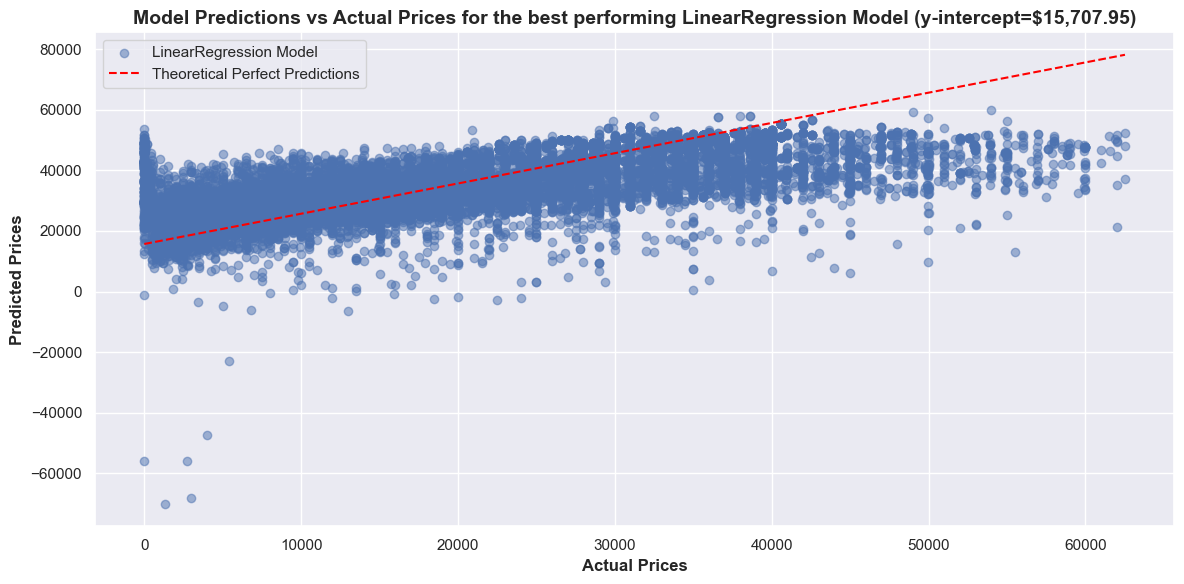

In [51]:
# Plot predictions
y_preds = best_model.predict(X_test_scaled)

# Adjust for the y-intercept
y_preds = np.add(y_preds, y_intercept)
perfect_pt_1 = [min(y_test), max(y_test)]
perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept

plt.figure(figsize=(12, 6))
plt.scatter(x=y_test, y=y_preds, label=f'{best_model_name} Model', alpha=0.5)
plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--', label='Theoretical Perfect Predictions')

plt.xlabel('Actual Prices', fontdict=axes_fonts)
plt.ylabel('Predicted Prices', fontdict=axes_fonts)
plt.title(f'Model Predictions vs Actual Prices for the best performing {best_model_name} Model (y-intercept=${y_intercept:,.2f})', 
          fontdict=title_fonts)
plt.legend()
plt.tight_layout()

plt.savefig('images/scatter-optimized-preds-v-test.png')
plt.show()

### PredictionErrorDisplay: Residuals Comparison

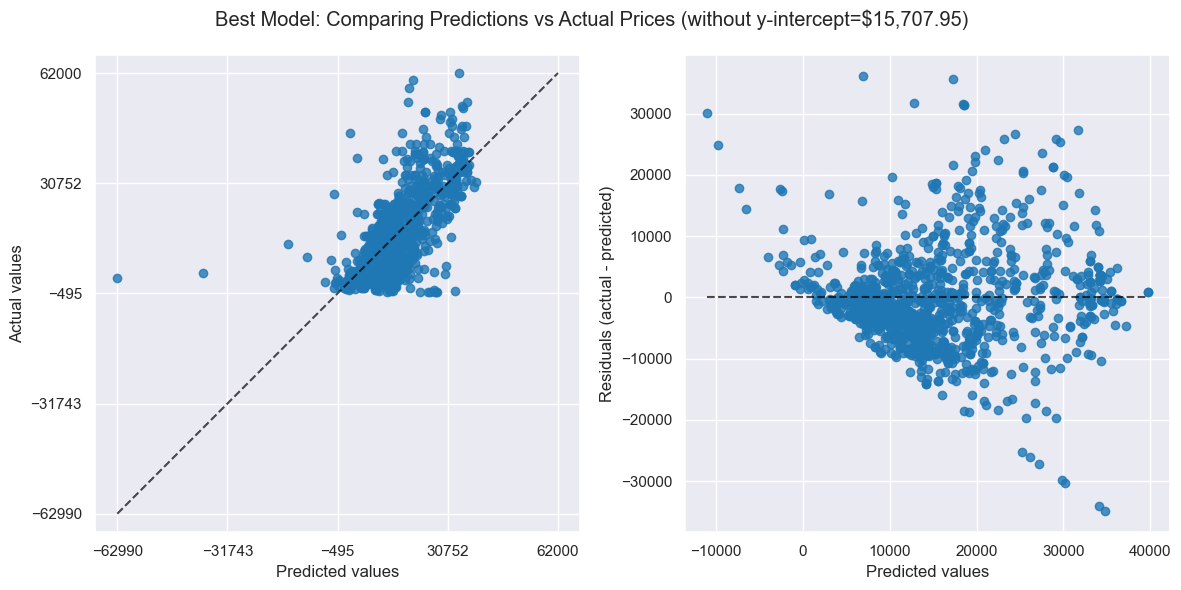

In [53]:
# # How to get the list of available Displays for my version of sklearn
# from sklearn.utils.discovery import all_displays
# displays = all_displays()
# displays

from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[0], kind="actual_vs_predicted")
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[1], kind="residual_vs_predicted")

plt.suptitle(f'Best Model: Comparing Predictions vs Actual Prices (without y-intercept=${y_intercept:,.2f})')
plt.tight_layout()

plt.savefig('images/optimized-PredictionErrorDisplay.png')
plt.show()

### Interpreting the Model Results

In [55]:
# build the feature importance DF

feature_names = X.columns

feature_imp = []
for feature, coef in zip(feature_names, best_model.coef_):
    if coef != 0:
        # print(f'{feature}: {coef}')
        feature_imp.append([feature, coef])

feature_imp_df = pd.DataFrame(data=feature_imp, columns=['Feature', 'Coefficient'])#.set_index('Feature')
feature_imp_df['Importance'] = np.abs(feature_imp_df.Coefficient)

# Sort the DF
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Add cumulative importance
feature_imp_df['Cumulative Importance'] = feature_imp_df['Importance'].cumsum() / feature_imp_df['Importance'].sum()
feature_imp_df['Percent Contribution'] = feature_imp_df['Cumulative Importance'] * 100

print(f'Impact of each feature to the Base Price: ${y_intercept:,.2f} (y-intercept)')
my_utils.df_style_floats(feature_imp_df[['Feature', 'Coefficient', 'Percent Contribution']].set_index('Feature').rename(columns={'Coefficient':'Price Impact'}).head())
# feature_imp_df_styled = my_utils.df_style_floats(feature_imp_df)
# feature_imp_df_styled

Impact of each feature to the Base Price: $15,707.95 (y-intercept)


,Price Impact,Percent Contribution
Feature,,
transmission_other,"3,904.4572",12.9363
year,"3,715.3842",25.2462
fuel_gas,"-2,236.9650",32.6577
cylinders_8 cylinders,"2,030.9523",39.3867
drive_fwd,"-1,889.2489",45.6462


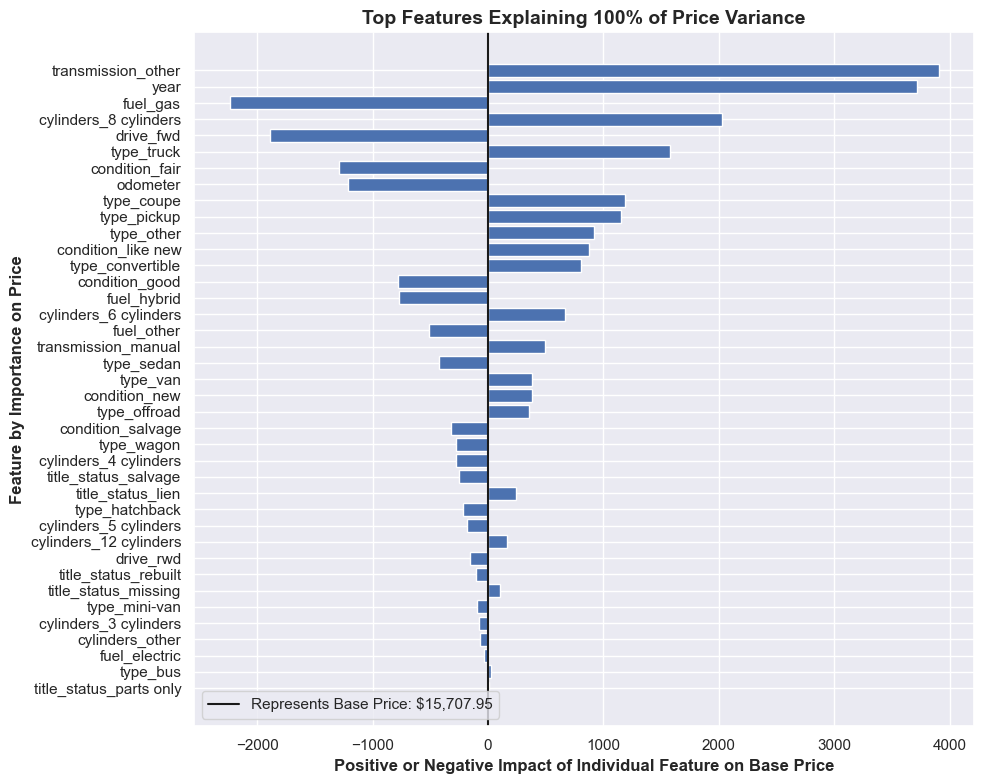

In [56]:
# Top features that explain X% of the variance
top_n = 1
top_features = feature_imp_df[feature_imp_df['Cumulative Importance'] <= top_n]

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.axvline(x=0, color="k", linestyle="-", label=f'Represents Base Price: ${y_intercept:,.2f}')

plt.xlabel(f'Positive or Negative Impact of Individual Feature on Base Price', fontdict=axes_fonts)
plt.ylabel('Feature by Importance on Price', fontdict=axes_fonts)

plt.title(f'Top Features Explaining {top_n * 100:,.0f}% of Price Variance', fontdict=title_fonts)
plt.gca().invert_yaxis()
plt.legend(loc='lower left')
plt.tight_layout()

plt.savefig('images/feature_importance.png')
plt.show()

## Segmentation Analysis

In [58]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,122682.0,15703.010751,12307.162365,1.0,6000.00,11599.0,23499.0,62950.0
year,122682.0,2009.325093,9.872852,1900.0,2006.00,2012.0,2015.0,2022.0
odometer,122682.0,111334.860517,194099.198408,0.0,55656.25,103000.0,148221.0,10000000.0


DEBUG: Segment: Budget, #Samples: 63156
DEBUG: X: (63156, 9) y: (63156,)
DEBUG: X_train: (50524, 39) X_test: (12632, 39) y_train: (50524,) y_test: (12632,)
DEBUG: X_scaled: (50524, 39) X_test_scaled: (12632, 39)
DEBUG: Score: 0.518690864796086, r2: 0.518690864796086, y_int: 9499.845063732104
DEBUG: Segment: Entry, #Samples: 5498
DEBUG: X: (5498, 9) y: (5498,)
DEBUG: X_train: (4398, 39) X_test: (1100, 39) y_train: (4398,) y_test: (1100,)
DEBUG: X_scaled: (4398, 39) X_test_scaled: (1100, 39)
DEBUG: Score: 0.6660355262266524, r2: 0.6660355262266524, y_int: 22460.089358799312
DEBUG: Segment: Mid, #Samples: 492
DEBUG: X: (492, 9) y: (492,)
DEBUG: X_train: (393, 39) X_test: (99, 39) y_train: (393,) y_test: (99,)
DEBUG: X_scaled: (393, 39) X_test_scaled: (99, 39)
DEBUG: Score: 0.7392448280932318, r2: 0.7392448280932318, y_int: 28051.310432569968
DEBUG: Segment: Upper, #Samples: 188
DEBUG: X: (188, 9) y: (188,)
DEBUG: X_train: (150, 39) X_test: (38, 39) y_train: (150,) y_test: (38,)
DEBUG: X_s

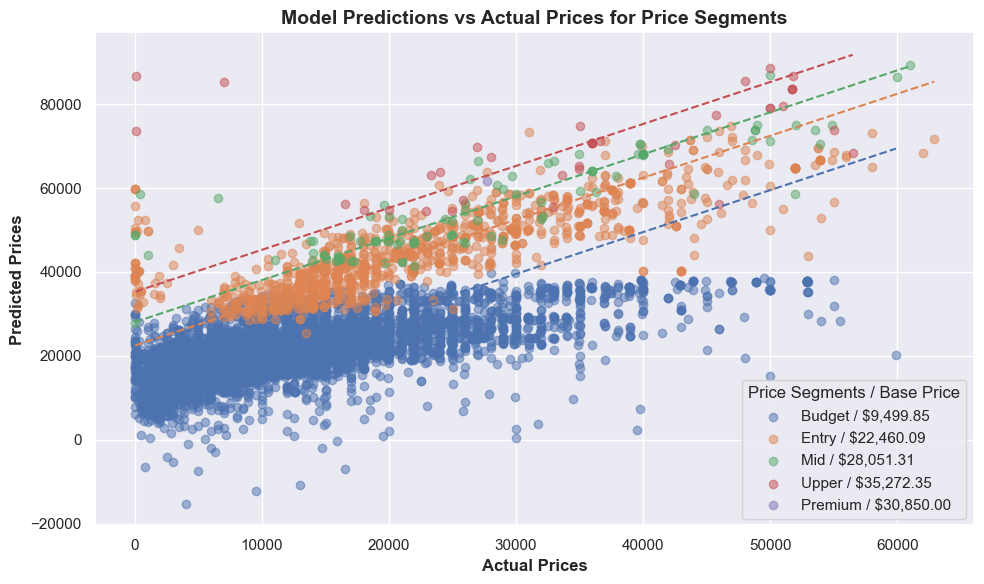

In [59]:
segments = {
    'Budget' : data.query('year <= 2016 and odometer >= 100000'),
    'Entry' : data.query('(year>=2016 and year<=2019) and (odometer>=60000 and odometer<=100000)'),
    'Mid' : data.query('(year>=2019 and year<=2021) and (odometer>=40000 and odometer<=60000)'),
    'Upper' : data.query('(year>=2021 and year<=2023) and (odometer<=30000)'),
    'Premium' : data.query('(year>=2022) and (odometer<=20000)')
}

logging.getLogger().setLevel(logging.DEBUG)

plt.figure(figsize=(page_width,6))

# seg_preds = {}
for segment in segments:
    logging.debug(f'Segment: {segment}, #Samples: {len(segments[segment])}')

    if len(segments[segment]) <= 0:
        continue
    
    # Predict on the segment
    X = segments[segment].drop('price', axis='columns')
    y = segments[segment]['price']
    logging.debug(f'X: {X.shape} y: {y.shape}')

    # transform the data: OneHotEncoding
    X = pd.get_dummies(X, drop_first=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    logging.debug(f'X_train: {X_train.shape} X_test: {X_test.shape} y_train: {y_train.shape} y_test: {y_test.shape}')

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    logging.debug(f'X_scaled: {X_train_scaled.shape} X_test_scaled: {X_test_scaled.shape}')

    best_model.fit(X_train_scaled, y_train)
    
    # Plot predictions
    y_preds = best_model.predict(X_test_scaled)
    score = best_model.score(X_test_scaled, y_test)
    r2 = r2_score(y_test, y_preds)
    y_intercept = best_model.intercept_
    logging.debug(f'Score: {score}, r2: {r2}, y_int: {y_intercept}')
    y_preds = y_preds + y_intercept
    # seg_preds[segment] = y_preds

    perfect_pt_1 = [min(y_test), max(y_test)]
    # perfect_pt_2 = [min(y_test), max(y_test)]
    perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept
    plt.scatter(x=y_test, y=y_preds, label=f'{segment} / ${y_intercept:,.2f}', alpha=0.5)
    plt.plot(perfect_pt_1, perfect_pt_2, linestyle='--')

plt.xlabel('Actual Prices', fontdict=axes_fonts)
plt.ylabel('Predicted Prices', fontdict=axes_fonts)
plt.title(f'Model Predictions vs Actual Prices for Price Segments', fontdict=title_fonts)
plt.legend().set_title('Price Segments / Base Price')
plt.tight_layout()

plt.savefig('images/scatter-segments-preds-v-test.png')
plt.show()

logging.getLogger().setLevel(logging.INFO)

#### Single Segment

In [61]:
# Predict on the segment
seg = 'Mid'
X = segments[seg].drop('price', axis='columns')
y = segments[seg]['price']

# Transform the data
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

best_model.fit(X_train_scaled, y_train)

LinearRegression()

In [62]:
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_scaled.shape)

(492, 39) (492,) (393, 39) (99, 39) (393,) (99,) (393, 39)


In [63]:
# Plot predictions
y_preds = best_model.predict(X_test_scaled)
score = best_model.score(X_test_scaled, y_test)
r2 = r2_score(y_test, y_preds)
logging.debug(f'Score: {score}, r2: {r2}')
y_intercept = best_model.intercept_

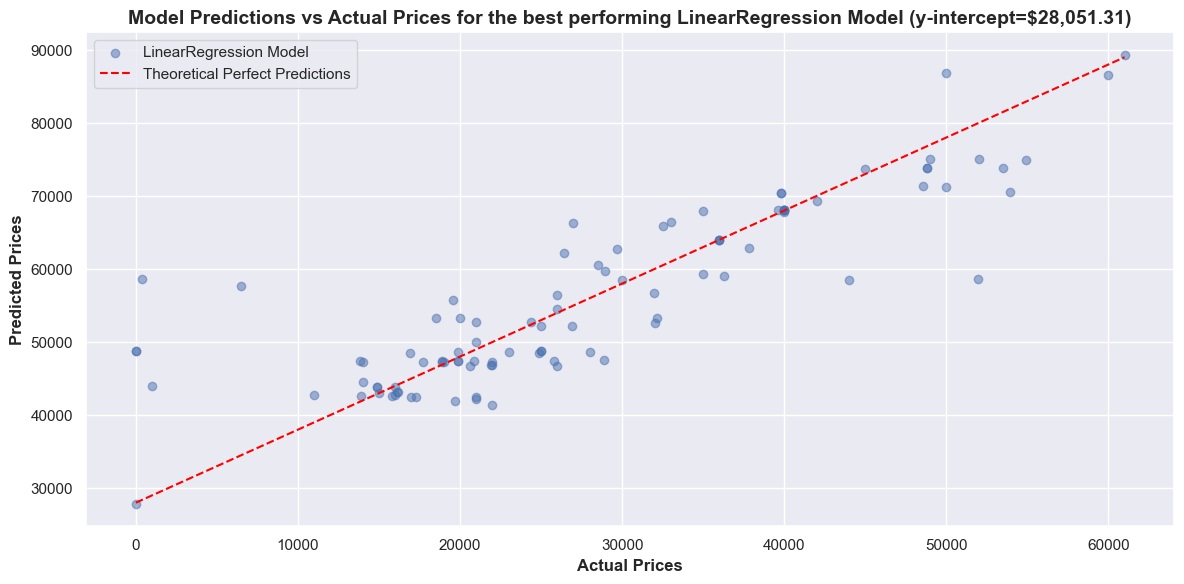

In [64]:
# Adjust for the y-intercept
y_preds = np.add(y_preds, y_intercept)
perfect_pt_1 = [min(y_test), max(y_test)]
perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept

plt.figure(figsize=(12, 6))
plt.scatter(x=y_test, y=y_preds, label=f'{best_model_name} Model', alpha=0.5)
plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--', label='Theoretical Perfect Predictions')
plt.xlabel('Actual Prices', fontdict=axes_fonts)
plt.ylabel('Predicted Prices', fontdict=axes_fonts)
plt.title(f'Model Predictions vs Actual Prices for the best performing {best_model_name} Model (y-intercept=${y_intercept:,.2f})', 
          fontdict=title_fonts)
plt.legend()
plt.tight_layout()

plt.savefig('images/scatter-optimized-preds-v-test.png')
plt.show()

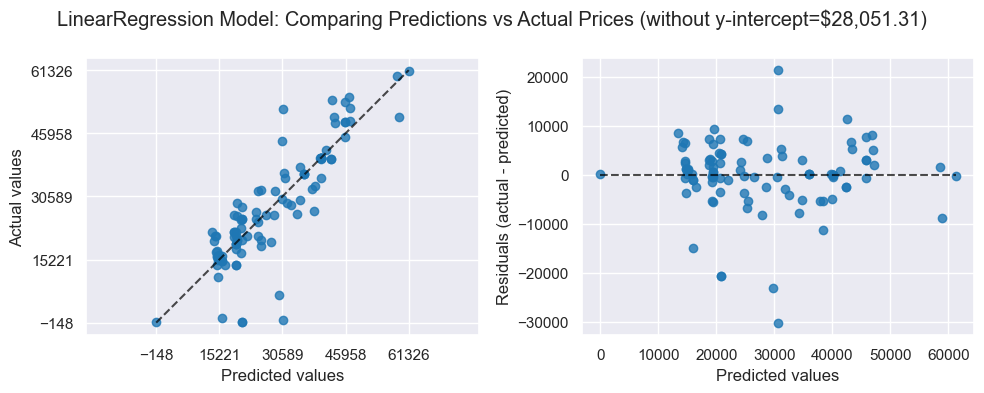

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[0], kind="actual_vs_predicted")
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[1], kind="residual_vs_predicted")

plt.suptitle(f'{best_model_name} Model: Comparing Predictions vs Actual Prices (without y-intercept=${y_intercept:,.2f})')
plt.tight_layout()

# plt.savefig('images/budget_predictions.png')
plt.show()